# Time Series analysis with statsmodels

https://allendowney.github.io/ThinkStats/time_series.html

A timeseries is usually\
- Repeated measurement over time
- Overtime

Timeseries are special\
- Lots of correlation
- Often periodic patterns
- Sometimes distinctive noise

So specialised methods can be useful\

## Outline
- Seasonal decomposition
- Prediction
- Autoregression
- ARIMA

### 2 datasets
1. US Energy information admin: monthly electricity generation from renewable 2001 to 2024
2.

### Seasonal Decomposotion
Model of time series compose of 

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")
!mv thinkstats.py ../src/pydata_2024/thinkstats.py

Downloaded thinkstats.py


## Electricity

In [2]:
filename = "Net_generation_for_all_sectors.csv"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)
!mv Net_generation_for_all_sectors.csv ../data/01_raw/TS_statsmodels/Net_generation_for_all_sectors.csv

Downloaded Net_generation_for_all_sectors.csv


In [3]:
from pathlib import Path
import sys

sys.path.append('../src')
from pydata_2024.thinkstats import decorate

data_raw = Path("../data/01_raw")

elec = pd.read_csv(f"{data_raw}/TS_statsmodels/Net_generation_for_all_sectors.csv", skiprows=4)\
                   .drop(columns=["units", "source key"])\
                    .set_index("description")\
                        .replace("--", np.nan)\
                            .transpose()\
                                .astype(float)

In [4]:
elec.columns

Index(['Net generation for all sectors', 'United States',
       'United States : all fuels (utility-scale)', 'United States : nuclear',
       'United States : conventional hydroelectric',
       'United States : other renewables', 'United States : wind',
       'United States : all utility-scale solar', 'United States : geothermal',
       'United States : biomass',
       'United States : hydro-electric pumped storage',
       'United States : all solar',
       'United States : small-scale solar photovoltaic'],
      dtype='object', name='description')

In [5]:
elec.index[:12]

Index(['Jan 2001', 'Feb 2001', 'Mar 2001', 'Apr 2001', 'May 2001', 'Jun 2001',
       'Jul 2001', 'Aug 2001', 'Sep 2001', 'Oct 2001', 'Nov 2001', 'Dec 2001'],
      dtype='object')

In [6]:
elec.head()

description,Net generation for all sectors,United States,United States : all fuels (utility-scale),United States : nuclear,United States : conventional hydroelectric,United States : other renewables,United States : wind,United States : all utility-scale solar,United States : geothermal,United States : biomass,United States : hydro-electric pumped storage,United States : all solar,United States : small-scale solar photovoltaic
Jan 2001,NaN,NaN,NaN,68707.0,18852.0,NaN,389.0,7.0,1229.0,4400.0,-589.0,NaN,NaN
Feb 2001,NaN,NaN,NaN,61272.0,17473.0,NaN,431.0,13.0,1073.0,3793.0,-707.0,NaN,NaN
Mar 2001,NaN,NaN,NaN,62141.0,20477.0,NaN,532.0,31.0,1190.0,4042.0,-773.0,NaN,NaN
Apr 2001,NaN,NaN,NaN,56003.0,18013.0,NaN,685.0,39.0,1095.0,4008.0,-796.0,NaN,NaN
May 2001,NaN,NaN,NaN,61512.0,19176.0,NaN,635.0,81.0,1071.0,3951.0,-623.0,NaN,NaN


In [7]:
elec.index = pd.date_range(start="2001-01", periods = len(elec), freq = "ME")
elec.index[:6]

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30'],
              dtype='datetime64[ns]', freq='ME')

## Decomposition

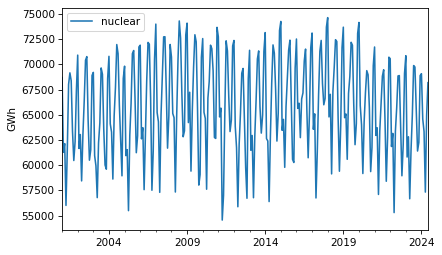

In [8]:
nuclear = elec["United States : nuclear"]
nuclear.plot(label="nuclear")

decorate(ylabel="GWh")

In [9]:
trend = nuclear.rolling(window=12).mean()

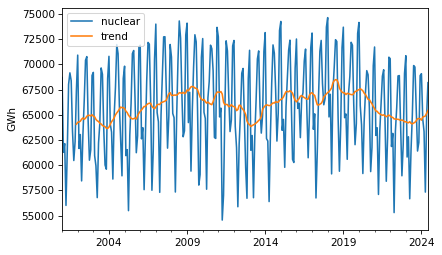

In [10]:
nuclear.plot(label = "nuclear")
trend.plot(label = "trend")
decorate(ylabel = "GWh")

In [11]:
detrended = (nuclear - trend).dropna()

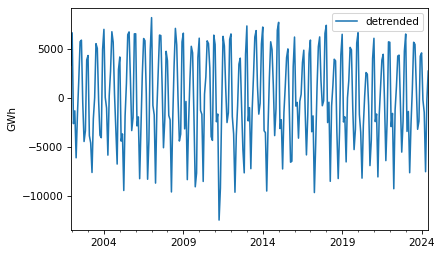

In [12]:
detrended.plot(label = "detrended")
decorate(ylabel = "GWh")

In [13]:
monthly_averages = detrended.groupby(detrended.index.month).mean()

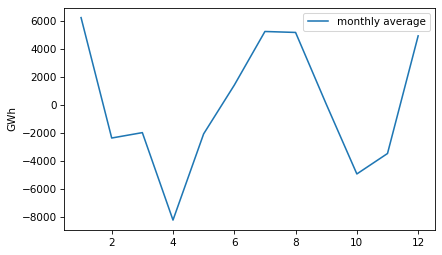

In [14]:
monthly_averages.plot(label = "monthly average")
decorate(ylabel = "GWh")

In [15]:
seasonal = monthly_averages[nuclear.index.month]
seasonal.index = nuclear.index

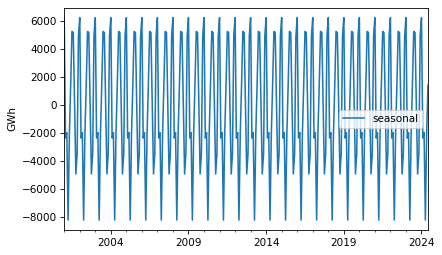

In [16]:
seasonal.plot(label = 'seasonal')
decorate(ylabel = "GWh")

In [17]:
expected = trend + seasonal

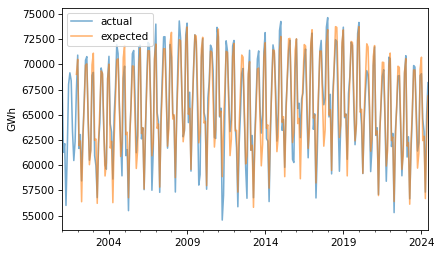

In [18]:
nuclear.plot(label = "actual", alpha=0.6)
expected.plot(color="C1", alpha=0.6, label = "expected")
decorate(ylabel = "GWh")

In [19]:
resid = nuclear - expected

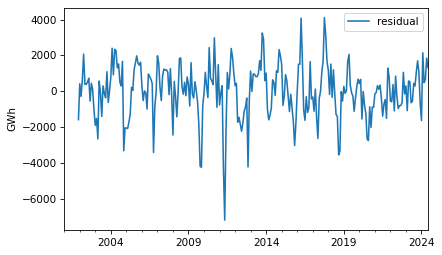

In [20]:
resid.plot(label = "residual")
decorate(ylabel = "GWh")

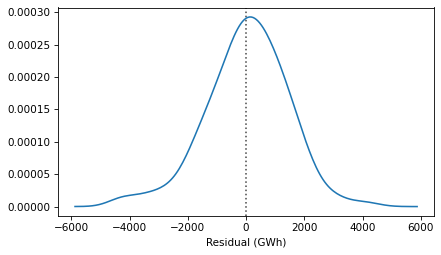

In [21]:
from pydata_2024.thinkstats import plot_kde

plot_kde(resid.dropna())
decorate(xlabel = "Residual (GWh)")

In [22]:
rsquared = 1 - resid.var() / nuclear.var()
rsquared

0.9054559977517084

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(nuclear, model = "additive", period=12)

In [24]:
def plot_decomposition(original, decomposition):
    plt.figure(figsize=(6, 5))

    ax1 = plt.subplot(4, 1, 1)
    plt.plot(original, label="Original", color="C0")
    plt.ylabel("Original")

    plt.subplot(4, 1, 2, sharex=ax1)
    plt.plot(decomposition.trend, label="Trend", color="C1")
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3, sharex=ax1)
    plt.plot(decomposition.seasonal, label="Seasonal", color="C2")
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4, sharex=ax1)
    plt.plot(decomposition.resid, label="Residual", color="C3")
    plt.ylabel("Residual")

    plt.tight_layout()

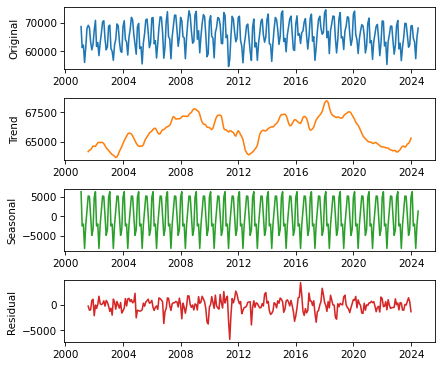

In [25]:
plot_decomposition(nuclear, decomposition)

### Exercise

As an example of seasonal decomposition, let's model monthly average surface temperatures in the United States.
We'll use a dataset from Our World in Data that includes "temperature [in Celsius] of the air measured 2 meters above the ground, encompassing land, sea, and in-land water surfaces," for most countries in the world from 1941 to 2024.

In [26]:
import requests

# Define the URL
url = "https://ourworldindata.org/grapher/average-monthly-surface-temperature.metadata.json"
query_params = {
    "v": "1",
    "csvType": "full",
    "useColumnShortNames": "true"
}
headers = {'User-Agent': 'Our World In Data data fetch/1.0'}

# Send the GET request with the query parameters
response = requests.get(url, params=query_params, headers=headers)
metadata = response.json()

In [27]:
from pprint import pprint

pprint(metadata['columns']['temperature_2m'])

{'citationLong': 'Contains modified Copernicus Climate Change Service '
                 'information (2019) – with major processing by Our World in '
                 'Data. “Annual average” [dataset]. Contains modified '
                 'Copernicus Climate Change Service information, “ERA5 monthly '
                 'averaged data on single levels from 1940 to present 2” '
                 '[original data].',
 'citationShort': 'Contains modified Copernicus Climate Change Service '
                  'information (2019) – with major processing by Our World in '
                  'Data',
 'descriptionKey': [],
 'descriptionProcessing': '- Temperature measured in kelvin was converted to '
                          'degrees Celsius (°C) by subtracting 273.15.\n'
                          '\n'
                          '- Initially, the temperature dataset is provided '
                          'with specific coordinates in terms of longitude and '
                          'latitude. To

In [28]:
country_code = "GBR"
base_url = "https://ourworldindata.org/grapher/average-monthly-surface-temperature.csv"

query_params = {
    "v": "1",
    "csvType": "filtered",
    "useColumnShortNames": "true",
    "tab": "chart",
    "country": country_code  
}


In [29]:
from urllib.parse import urlencode

url = f"{base_url}?{urlencode(query_params)}"
temp_df = pd.read_csv(url, storage_options=headers)

In [30]:
temp_df.head()

,Entity,Code,year,Day,temperature_2m,temperature_2m.1
0,United Kingdom,GBR,1941,1941-12-15,5.252781,8.146564
1,United Kingdom,GBR,1942,1942-01-15,0.449082,7.872205
2,United Kingdom,GBR,1942,1942-02-15,-0.086144,7.872205
3,United Kingdom,GBR,1942,1942-03-15,3.686946,7.872205
4,United Kingdom,GBR,1942,1942-04-15,7.140402,7.872205


In [31]:
temp_series = temp_df['temperature_2m']
temp_series.index = pd.to_datetime(temp_df["Day"])

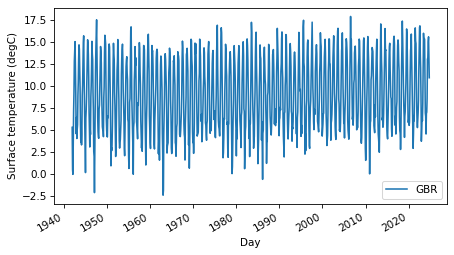

In [32]:
temp_series.plot(label=country_code)
decorate(ylabel = "Surface temperature (degC)")

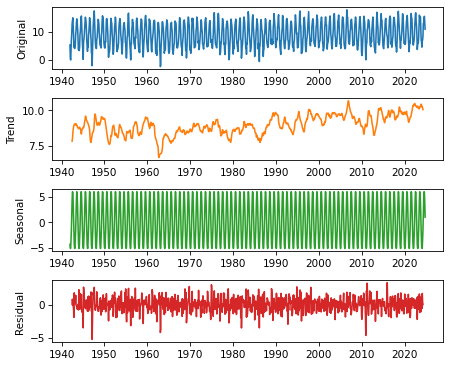

In [33]:
# Solution

decomposition = seasonal_decompose(temp_series, model = "additive", period=12)
plot_decomposition(temp_series, decomposition)

In [34]:
rswuared = 1-decomposition.resid.var() / temp_series.var()
rsquared

0.9054559977517084

### Prediction

We can use the results from seasonal decomposition to predict the future. To demonstrate, we will use teh following function to split the timeseries into a training series we will use to generate predictions and a tes series twe will use to see whether they are accurate.

In [35]:
def split_series(series, n=60):
    training = series.iloc[:-n]
    test = series.iloc[-n:]
    return training, test

In [36]:
training, test = split_series(nuclear)
test.index[0]

Timestamp('2019-07-31 00:00:00')

In [37]:
decomposition = seasonal_decompose(training, model = "additive", period = 12)
trend = decomposition.trend

In [38]:
import statsmodels.formula.api as smf

months = np.arange(len(trend))
data = pd.DataFrame({"trend": trend, "months": months}).dropna()
results = smf.ols("trend ~ months", data = data).fit()